In [23]:
import sys, math
import numpy as np
import glob

from skimage import io
from skimage.color import rgb2lab, lch2lab
from skimage.segmentation import slic, quickshift, felzenszwalb


from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import colors
import pylab
image_location = '/home/Alex/Desktop/bristol_project/bristol_tree_1.jpg'

sys.path.append('/home/Alex/Desktop/bristol_project/mplcursor')
import mpldatacursor

images = []

In [110]:
tree_im_rgb = io.imread(image_location)
tree_im_lab = rgb2lab(tree_im_rgb)

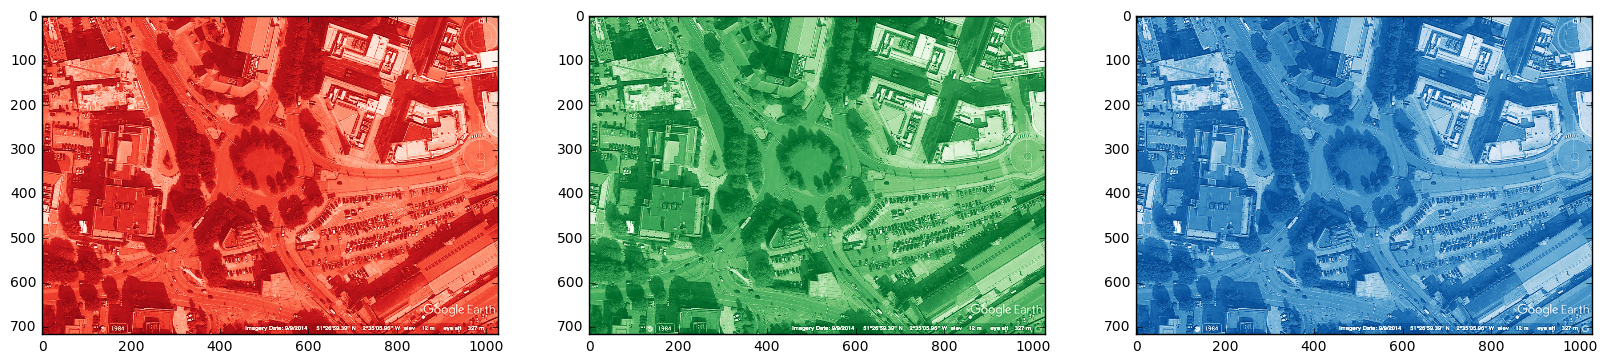

In [3]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20.0, 8.0)

col = ['Reds_r','Greens_r','Blues_r']

ff, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(tree_im_rgb[:, :, i], interpolation = None, cmap = col[i])

In [6]:
seg_trees = quickshift(tree_im_rgb, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(seg_trees))
print(n_segments)

7597


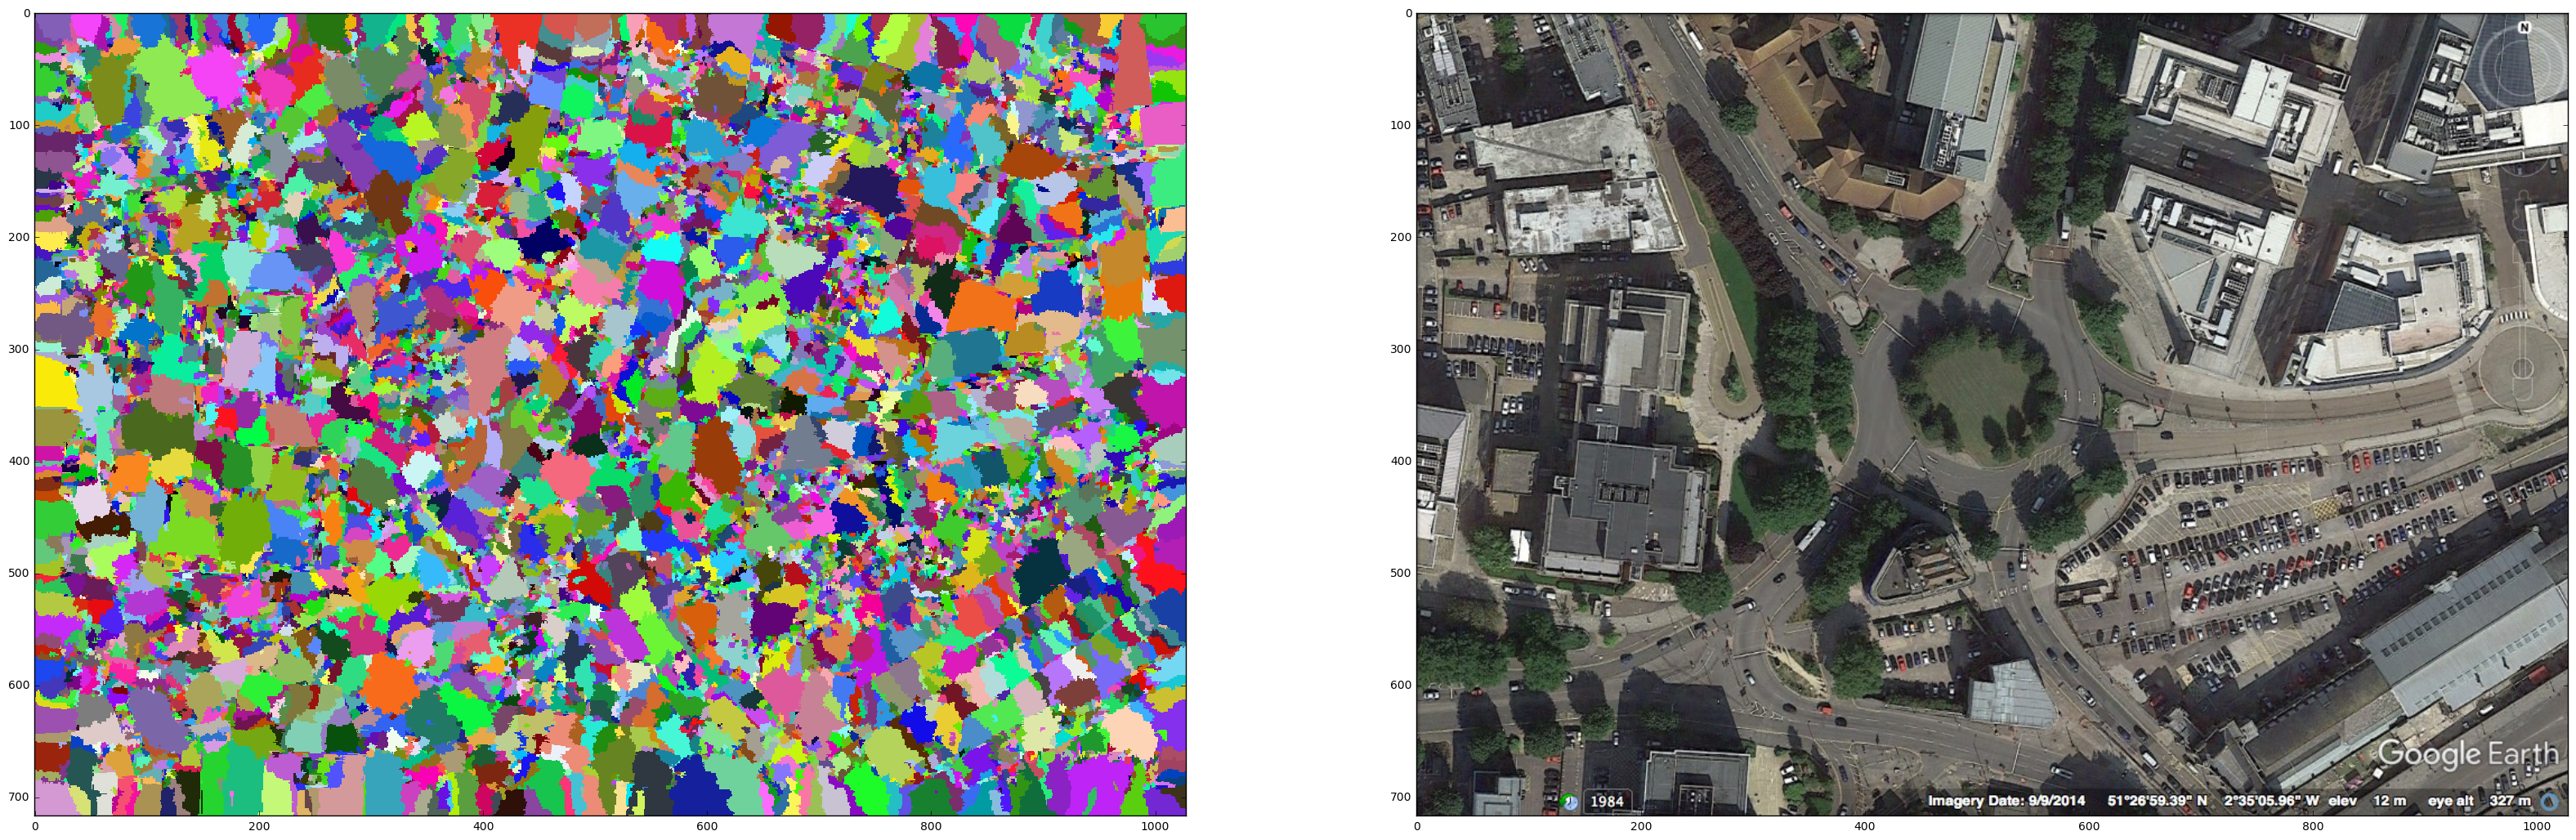

In [7]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (40.0, 20.0)
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
ff, ax = plt.subplots(1,2)
ax[0].imshow(seg_trees, interpolation='none', cmap=cmap)
ax[1].imshow(tree_im_rgb)

In [32]:
class UniqueDict(dict):
    def __setitem__(self, key, value):
        if key not in self:
            dict.__setitem__(self, key, value)
        else:
            raise KeyError("Key already exists")

segment_dict = UniqueDict()            
            
for x, row in enumerate(seg_trees):
    #
    for y, val in enumerate(row):
        try:
            segment_dict[val] = []
            segment_dict[val].append(tuple(tree_im_rgb[x,y]))
        except KeyError:
            segment_dict[val].append(tuple(tree_im_rgb[x,y]))
        

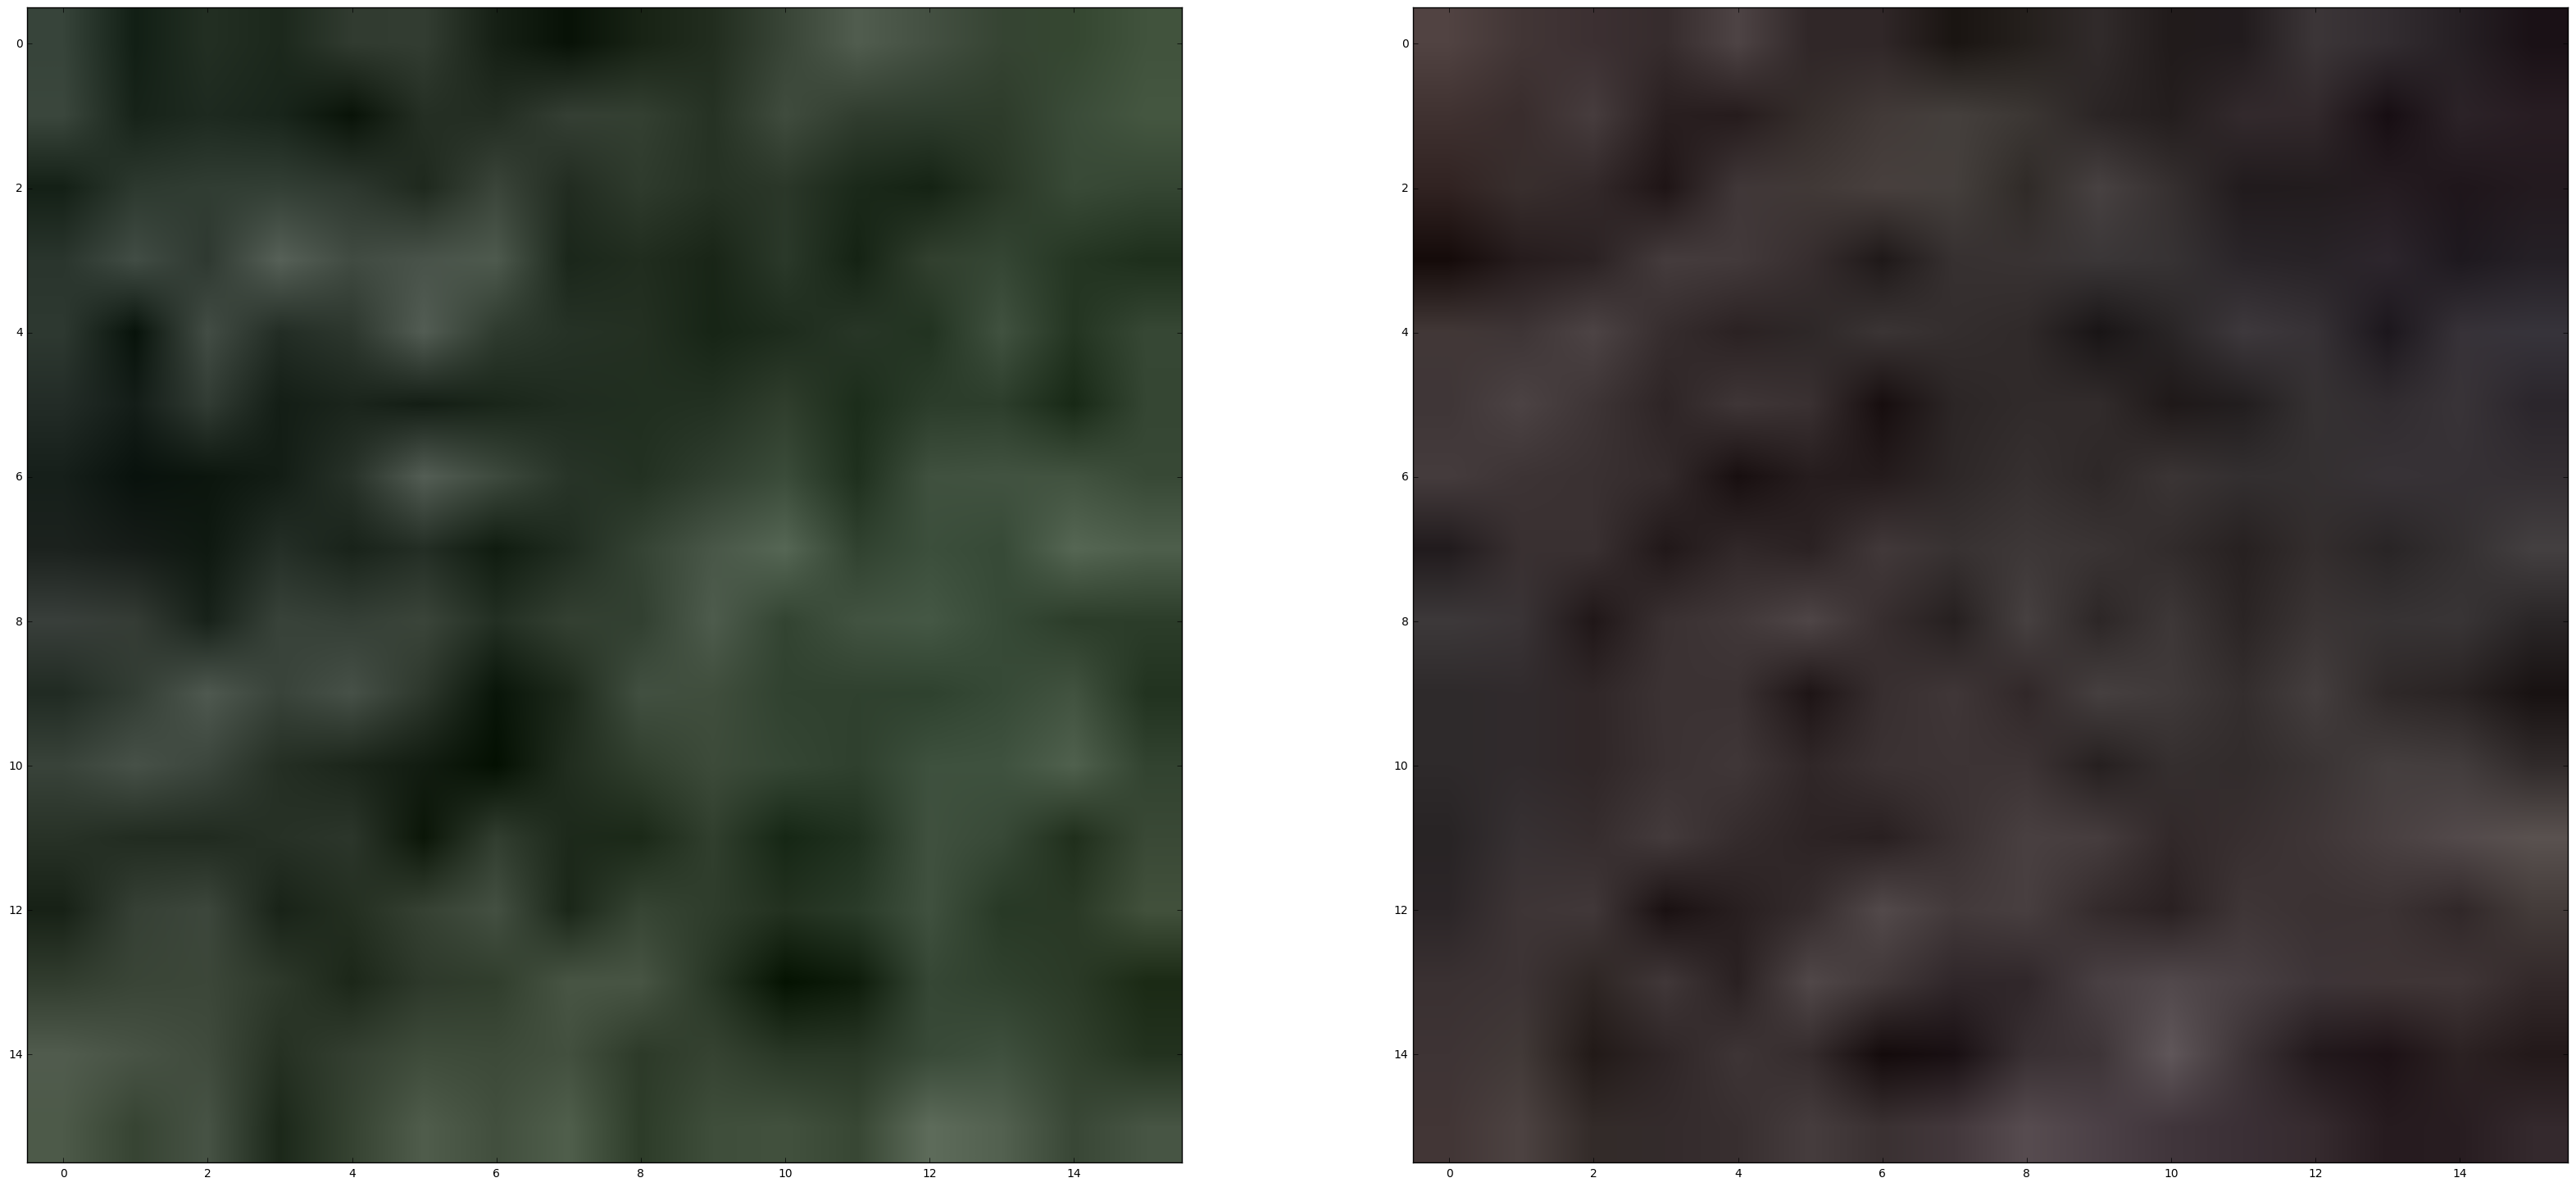

In [33]:
refs = glob.glob("/home/Alex/Desktop/bristol_project/bristol_reference_*.png")
ff, ax = plt.subplots(1, len(refs)) 

for i, r in enumerate(refs):
    refs[i] = io.imread(r)
    ax[i].imshow(refs[i], interpolation = None)

tree_pixels = []

for im in refs:
    for row in im:
        for val in row:
            tree_pixels.append(tuple(val))
            
tree_pixels = set(tree_pixels)

In [124]:
Threshold = 0.1
tree_segments = []

for key, rgb_list in segment_dict.items():
    thresh = 0
    for pixel in rgb_list:
        if pixel in tree_pixels:
            thresh += 1
    if thresh >= len(rgb_list)*Threshold:
        tree_segments.append(key)

In [127]:
new_image = np.zeros(seg_trees.shape)
for x, row in enumerate(seg_trees):
    for y, val in enumerate(row):
        if val in tree_segments:
            new_image[x,y] = 1

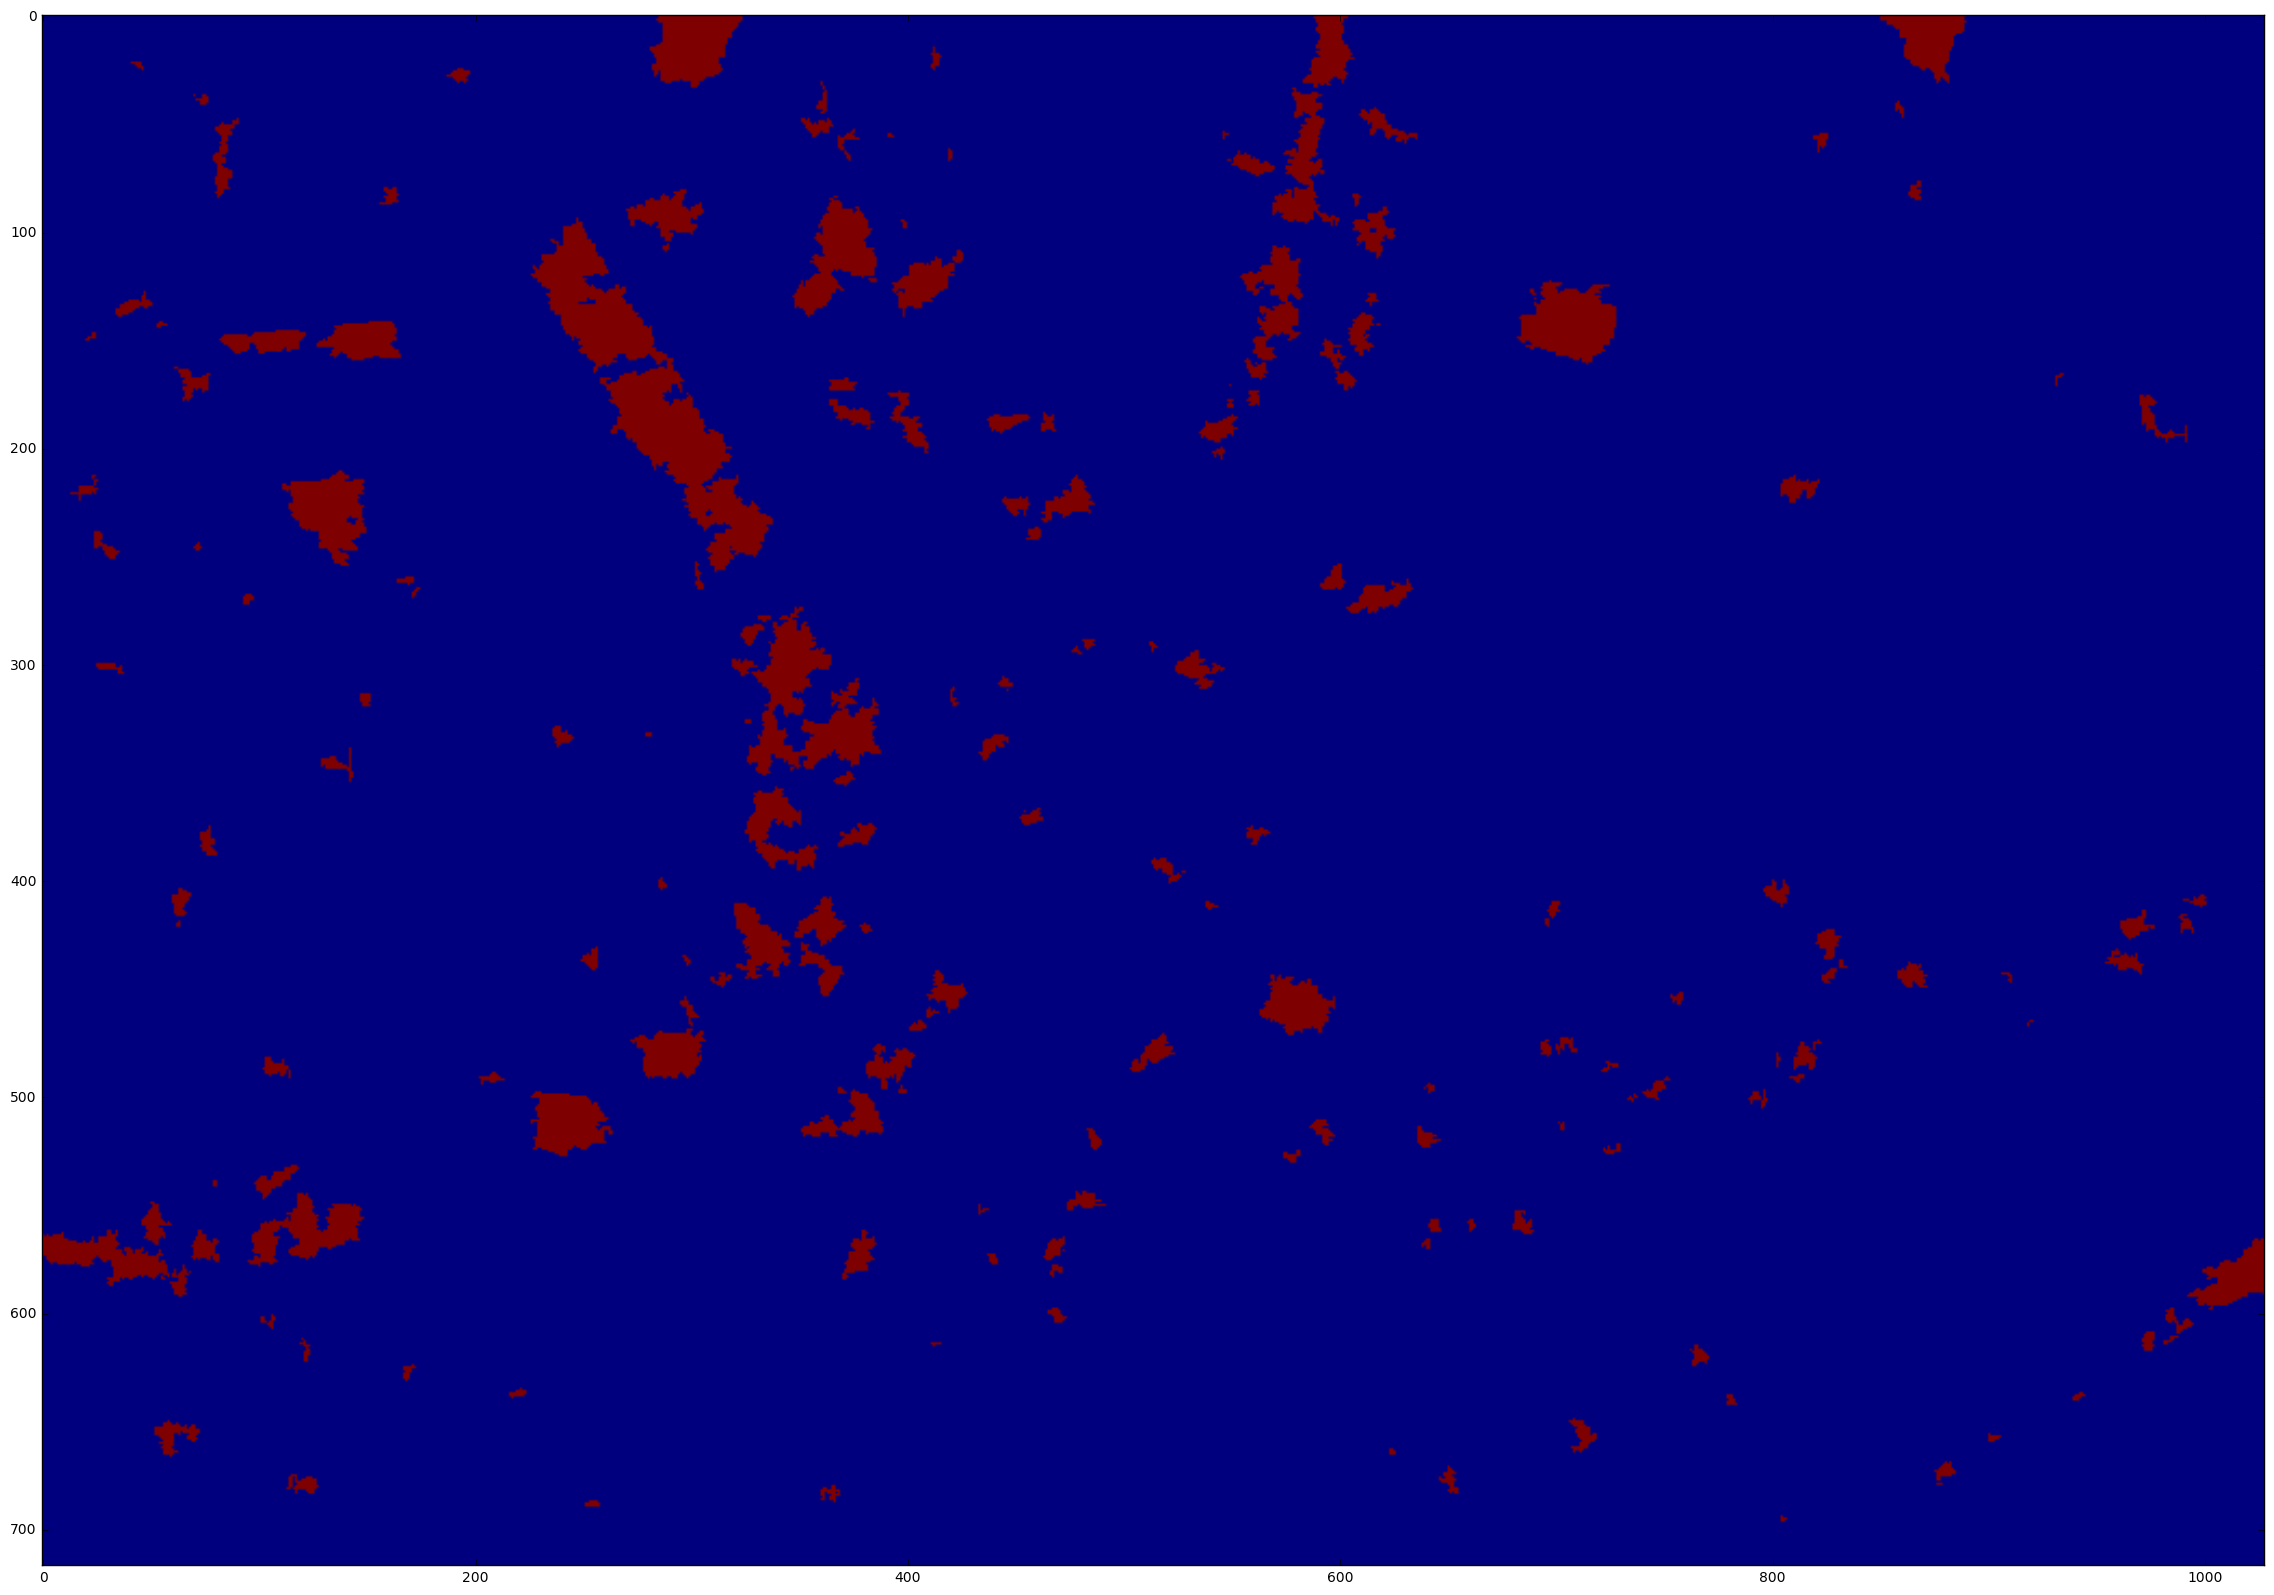

In [128]:
plt.imshow(new_image)

In [97]:
a = list(new_image.shape)
a.append(3)
print(a)

[717, 1028, 3]


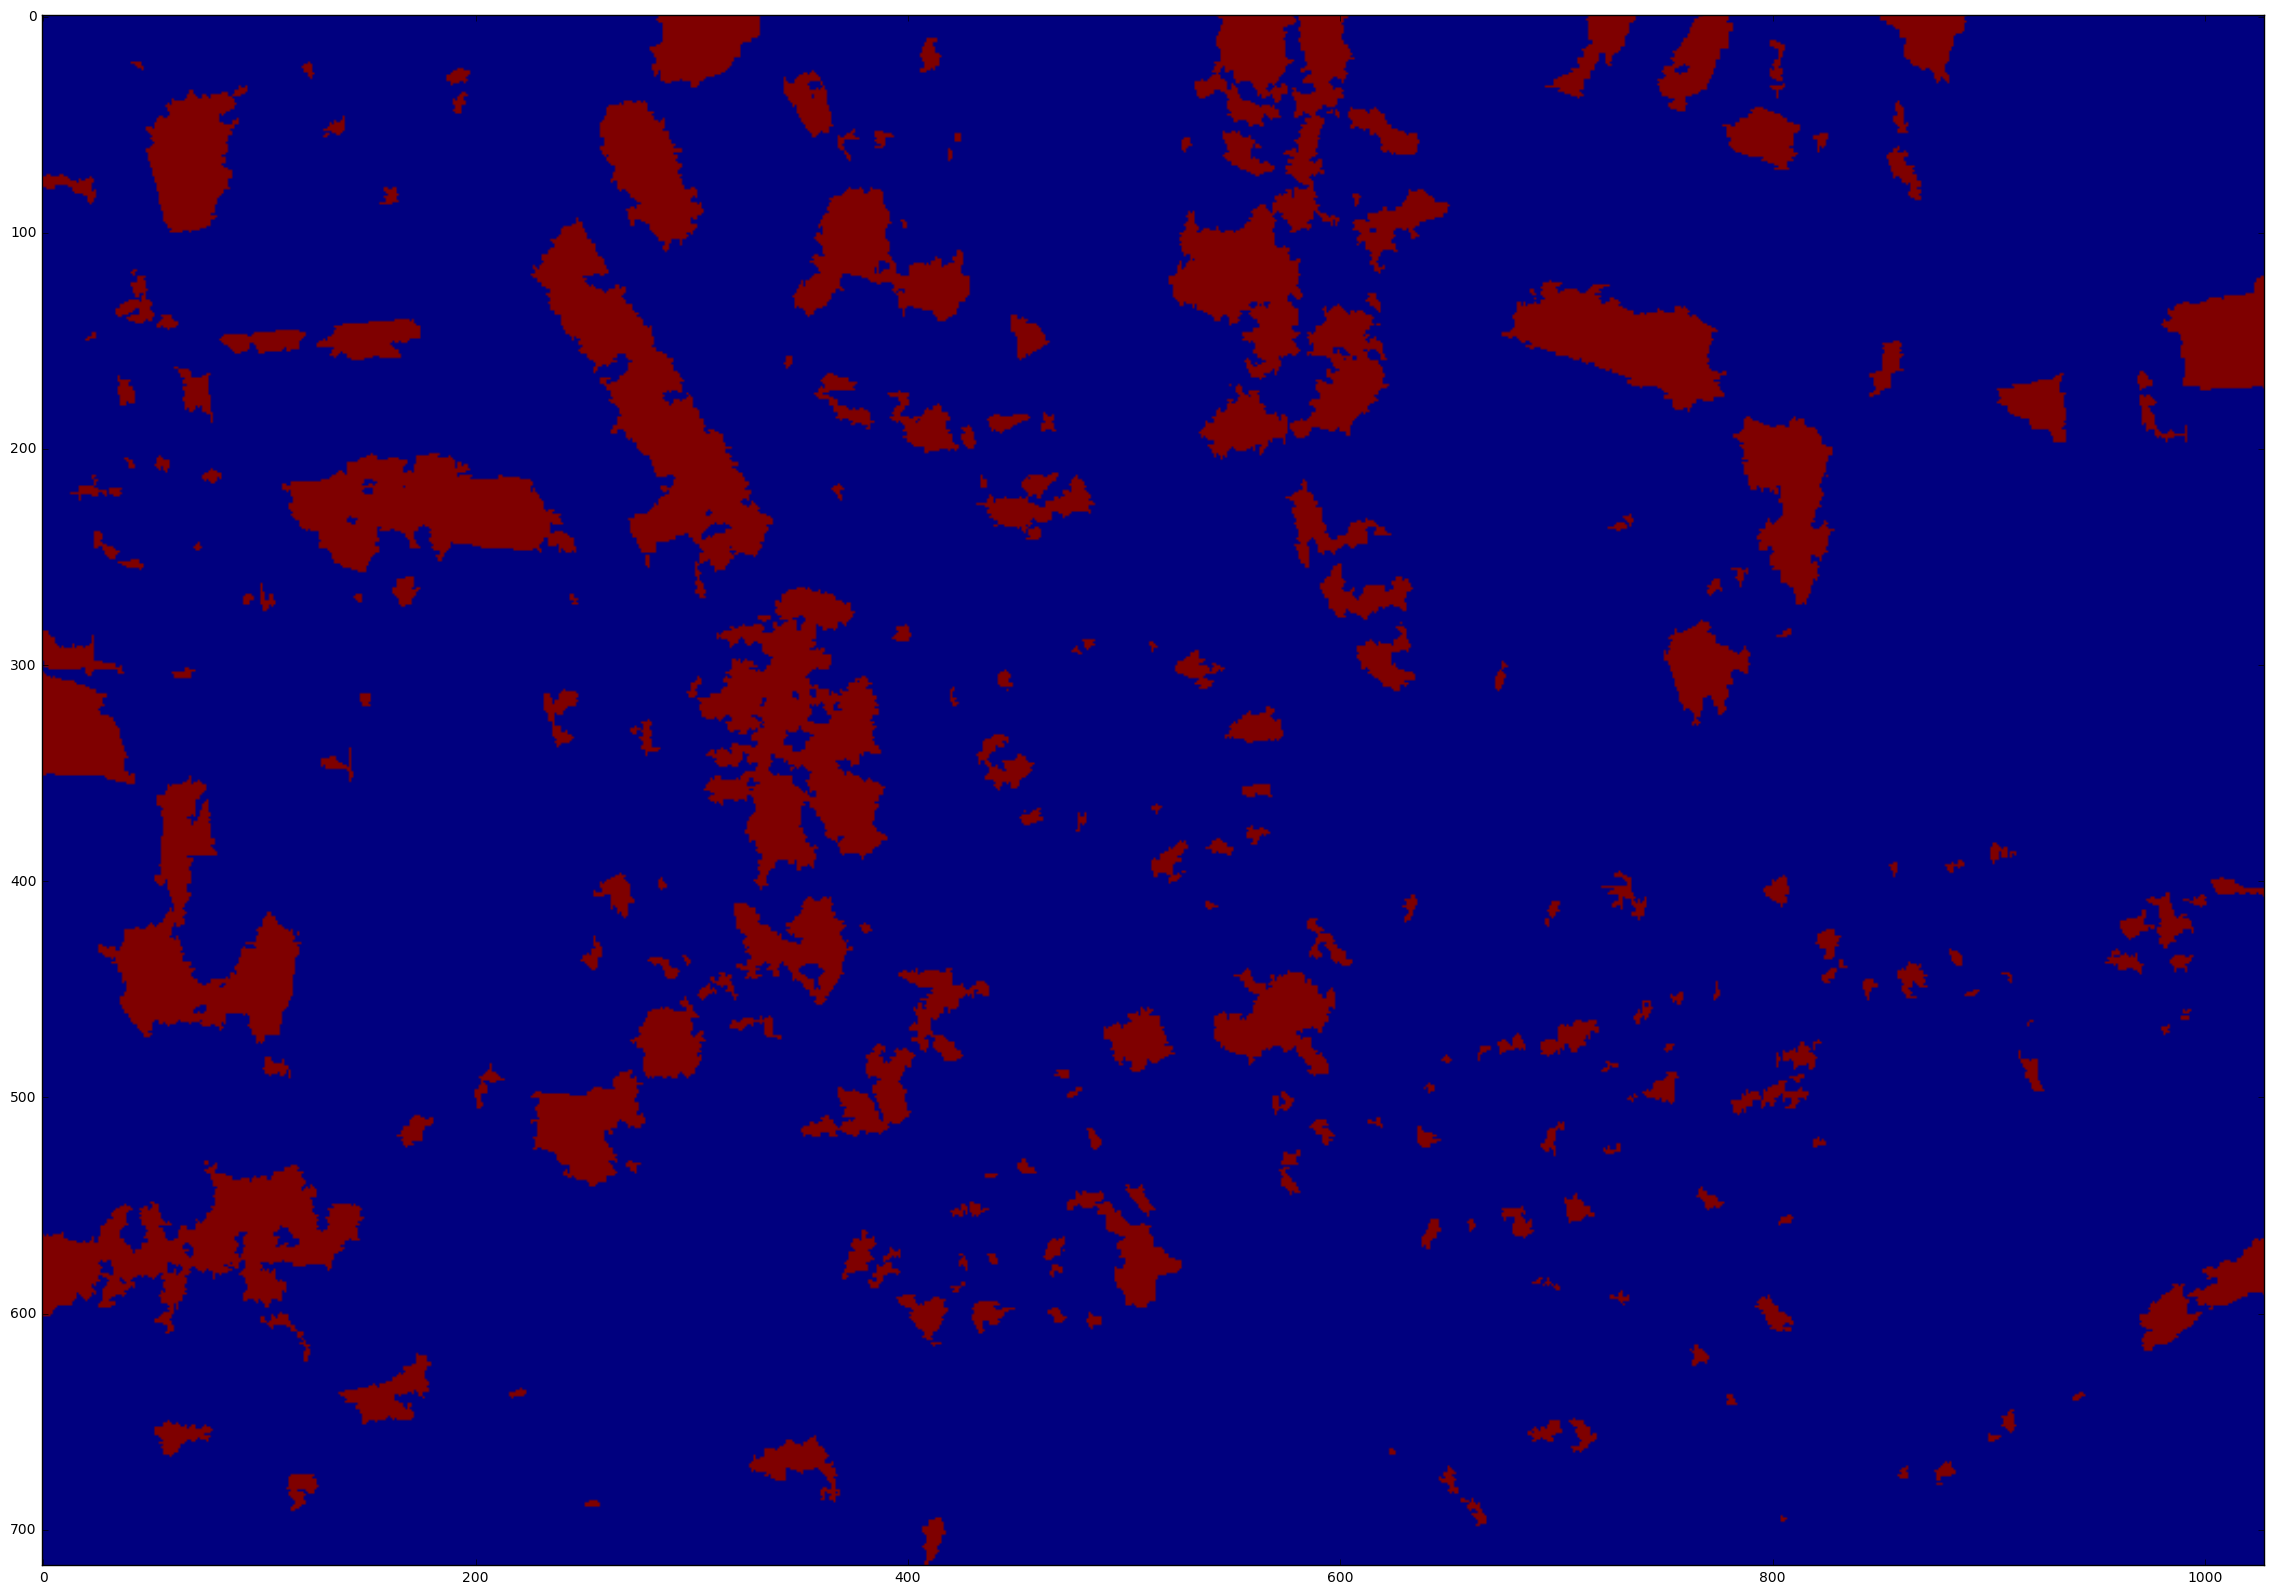

In [102]:
plt.imshow(mask)

In [138]:
a = set([(0,0,0),(1,1,1)])
a.discard((0,0,0))
print(a)

{(1, 1, 1)}


In [129]:
import copy
repl = copy.deepcopy(tree_im_rgb)
mask = new_image > 0
zeros = np.zeros(a)

for x in range(tree_im_rgb.shape[0]):
    for y in range(tree_im_rgb.shape[1]):
        if mask[x,y] == 0: 
            repl[x,y] = np.array([0,0,0])
        else:
            pass

In [107]:
new_image.shape, tree_im_rgb.shape

((717, 1028), (717, 1028, 3))

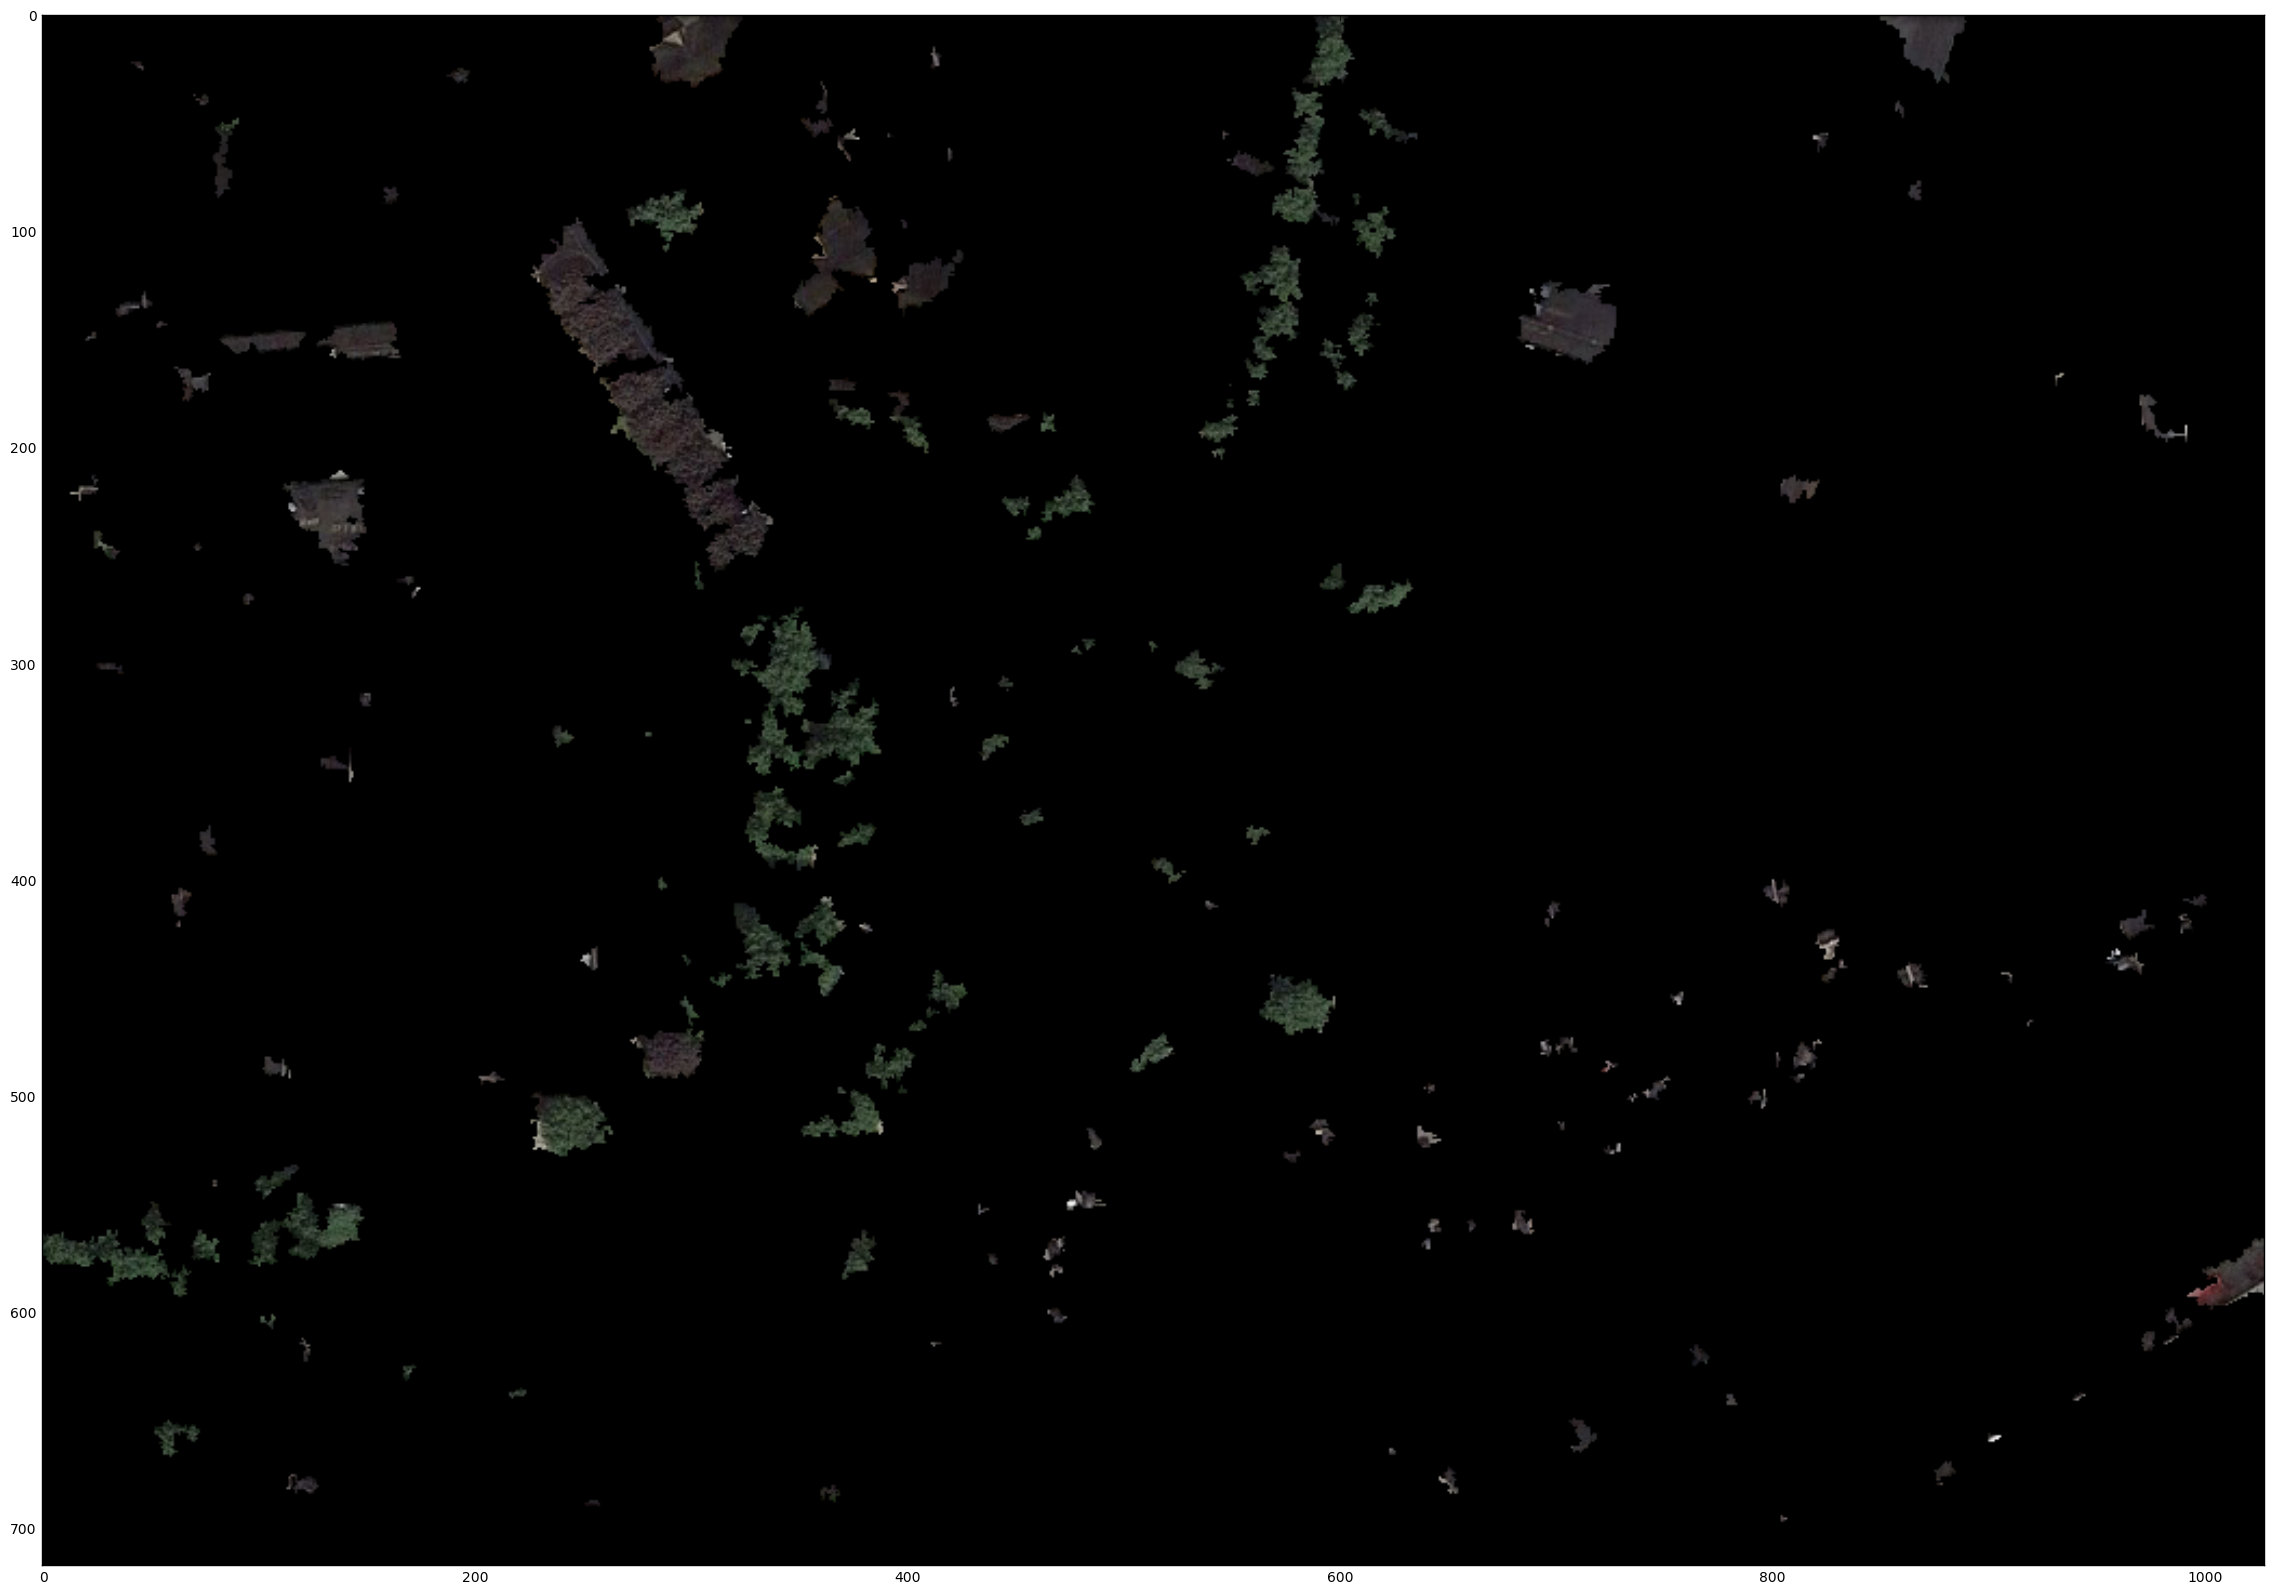

In [130]:
plt.imshow(repl)

In [84]:
masked = tree_im_rgb[mask]
for i in masked:
    if tuple(i) == (0,0,0): 
        pass
    else:
        print(i)

In [61]:
band_segmentation = []
for i in range(3):
    band_segmentation.append(felzenszwalb(tree_im_rgb[:, :, i], scale=85, sigma=0.25, min_size=9))

In [63]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(tree_im_rgb.shape[:2])

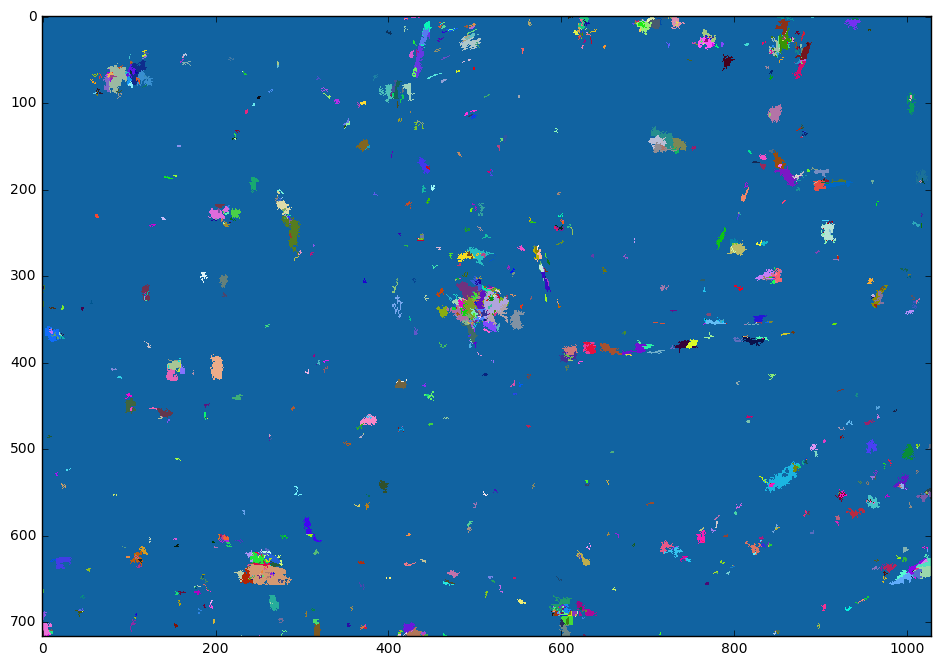

In [64]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

In [7]:
f, ax = plt.subplots(111)
im = ax.imshow(tree_im)
mpldatacursor.datacursor(im, hover=True)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

In [5]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f09a8addb00>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f09a6d11208>], dtype=object)

In [14]:
for lines in tree_im.shape:
    for pixels in lines:
        r = pixel[0]
        g = pixel[1]
        b = pixel[2]

(588, 3)

In [16]:
class AnnoteFinder(object):
    """callback for matplotlib to display an annotation when points are
    clicked on.  The point which is closest to the click and within
    xtol and ytol is identified.

    Register this function like this:

    scatter(xdata, ydata)
    af = AnnoteFinder(xdata, ydata, annotes)
    connect('button_press_event', af)
    """

    def __init__(self, xdata, ydata, annotes, ax=None, xtol=None, ytol=None):
        self.data = list(zip(xdata, ydata, annotes))
        if xtol is None:
            xtol = ((max(xdata) - min(xdata))/float(len(xdata)))/2
        if ytol is None:
            ytol = ((max(ydata) - min(ydata))/float(len(ydata)))/2
        self.xtol = xtol
        self.ytol = ytol
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.drawnAnnotations = {}
        self.links = []

    def distance(self, x1, x2, y1, y2):
        """
        return the distance between two points
        """
        return(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))

    def __call__(self, event):

        if event.inaxes:

            clickX = event.xdata
            clickY = event.ydata
            if (self.ax is None) or (self.ax is event.inaxes):
                annotes = []
                # print(event.xdata, event.ydata)
                for x, y, a in self.data:
                    # print(x, y, a)
                    if ((clickX-self.xtol < x < clickX+self.xtol) and
                            (clickY-self.ytol < y < clickY+self.ytol)):
                        annotes.append(
                            (self.distance(x, clickX, y, clickY), x, y, a))
                if annotes:
                    annotes.sort()
                    distance, x, y, annote = annotes[0]
                    self.drawAnnote(event.inaxes, x, y, annote)
                    for l in self.links:
                        l.drawSpecificAnnote(annote)

    def drawAnnote(self, ax, x, y, annote):
        """
        Draw the annotation on the plot
        """
        if (x, y) in self.drawnAnnotations:
            markers = self.drawnAnnotations[(x, y)]
            for m in markers:
                m.set_visible(not m.get_visible())
            self.ax.figure.canvas.draw_idle()
        else:
            t = ax.text(x, y, " - %s" % (annote),)
            m = ax.scatter([x], [y], marker='d', c='r', zorder=100)
            self.drawnAnnotations[(x, y)] = (t, m)
            self.ax.figure.canvas.draw_idle()

    def drawSpecificAnnote(self, annote):
        annotesToDraw = [(x, y, a) for x, y, a in self.data if a == annote]
        for x, y, a in annotesToDraw:
            self.drawAnnote(self.ax, x, y, a)


ValueError: too many values to unpack (expected 2)

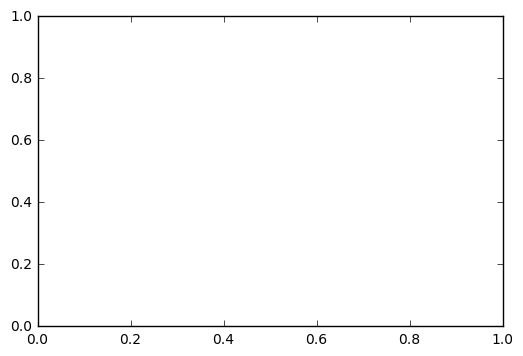

In [17]:
annotes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

fig, ax = plt.subplots()
ax.matshow(tree_im)
af =  AnnoteFinder(tree_im.shape[0], tree_im.shape[1], annotes, ax=ax)
fig.canvas.mpl_connect('button_press_event', af)
plt.show()